# Import libraries and data

In [ ]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.decomposition import PCA
from sklearn import preprocessing
from skimage import transform
from skimage import io 
from scipy import misc
import os
from PIL import Image
import random
import copy
from torch.utils.data.sampler import SubsetRandomSampler
import csv


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!unzip -qq GTSRB_Final_Test_Images.zip

!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
!unzip -qq GTSRB_Final_Test_GT.zip -d "GTSRB/Final_Test"

--2021-04-27 23:53:53--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  19.1MB/s    in 15s     

2021-04-27 23:54:10 (17.7 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]

--2021-04-27 23:54:16--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘GTSRB_Final_Test_Images.zip’

GTSRB_Final_Test_Im 100%[===================>]  84.8

In [ ]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
print("number of classes:", len(train_folders))
print("number of test images:", len(glob('GTSRB/Final_Test/Images/*')))

number of classes: 43
number of test images: 12631


In [ ]:
classnames = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']

#Exploratory Data Analysis and Initial Preprocessing

In [ ]:
distribution = {}
i = 0
for folder in train_folders:
  num = 0
  for file in os.listdir(folder):
    if file.endswith(".ppm"):
      num += 1
  distribution[classnames[i]] = num
  i += 1

In [ ]:
distribution

{'Ahead only': 1200,
 'Beware of ice/snow': 450,
 'Bicycles crossing': 270,
 'Bumpy road': 390,
 'Children crossing': 540,
 'Dangerous curve to the left': 210,
 'Dangerous curve to the right': 360,
 'Double curve': 330,
 'End of all speed and passing limits': 240,
 'End of no passing': 240,
 'End of no passing by vehicles over 3.5 metric tons': 240,
 'End of speed limit (80km/h)': 420,
 'General caution': 1200,
 'Go straight or left': 210,
 'Go straight or right': 390,
 'Keep left': 300,
 'Keep right': 2070,
 'No entry': 1110,
 'No passing': 1470,
 'No passing for vehicles over 3.5 metric tons': 2010,
 'No vehicles': 630,
 'Pedestrians': 240,
 'Priority road': 2100,
 'Right-of-way at the next intersection': 1320,
 'Road narrows on the right': 270,
 'Road work': 1500,
 'Roundabout mandatory': 360,
 'Slippery road': 510,
 'Speed limit (100km/h)': 1440,
 'Speed limit (120km/h)': 1410,
 'Speed limit (20km/h)': 210,
 'Speed limit (30km/h)': 2220,
 'Speed limit (50km/h)': 2250,
 'Speed limit

In [ ]:
pos = []
for i in range(43):
  pos.append(i)


Text(0, 0.5, 'Num of training samples')

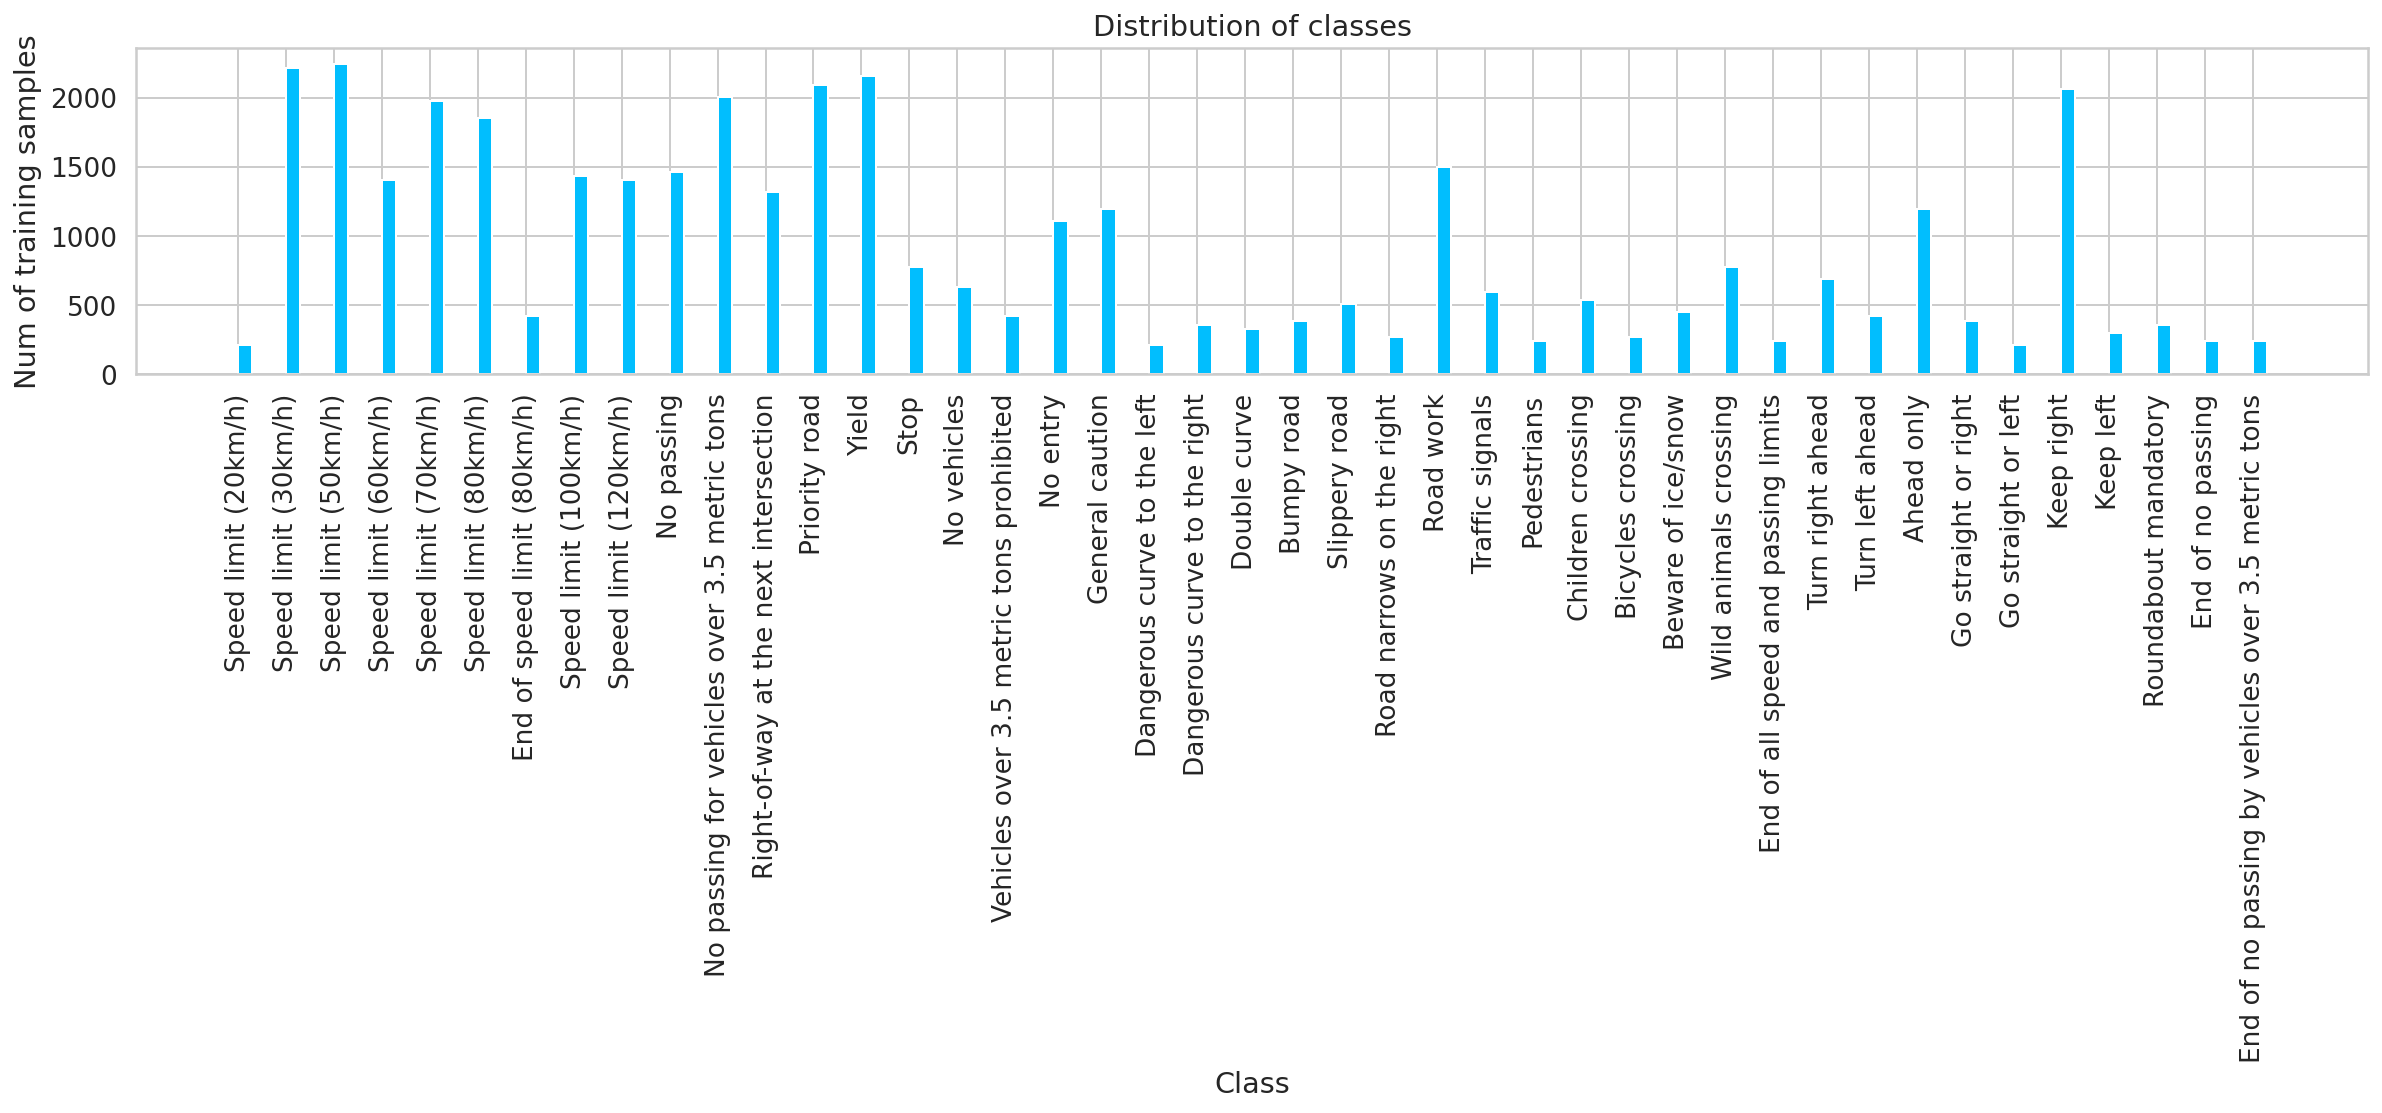

In [ ]:
plt.figure(figsize=(20, 3)) 
plt.bar(distribution.keys(), distribution.values(), align='edge', width=0.3)
plt.xticks(pos, distribution.keys(), rotation='vertical')
plt.title("Distribution of classes")
plt.xlabel("Class")
plt.ylabel("Num of training samples")

**********************************************
Image format and naming
**********************************************
The images are PPM images (RGB color). Files are numbered in two parts:

   XXXXX_YYYYY.ppm

The first part, XXXXX, represents the track number. All images of one class 
with identical track numbers originate from one single physical traffic sign.
The second part, YYYYY, is a running number within the track. The temporal order
of the images is preserved.

### Image read test code on a single sample

(36, 36, 3)
3888
[ 71  63  43 ... 255 255 255]


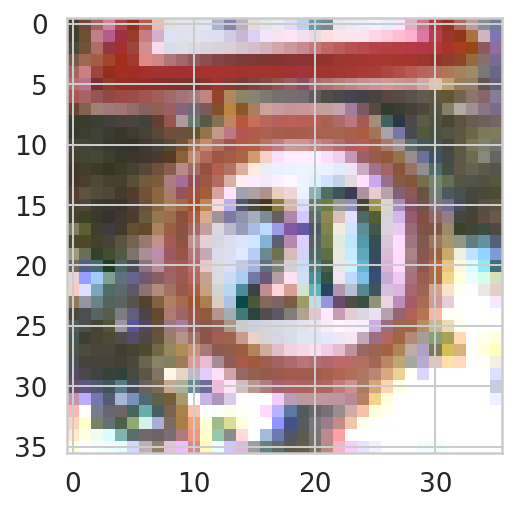

In [ ]:
img = plt.imread('/content/GTSRB/Final_Training/Images/00000/00001_00012.ppm')
print(img.shape)
rows,cols,colors = img.shape # gives dimensions for RGB array
img_size = rows*cols*colors
print(img_size)
img_1D_vector = img.reshape(img_size)
print(img_1D_vector)
# you can recover the orginal image with:
img2 = img_1D_vector.reshape(rows,cols,colors)

plt.imshow(img2)

(54, 53, 3)
8586
[115 138 173 ... 115 140 172]


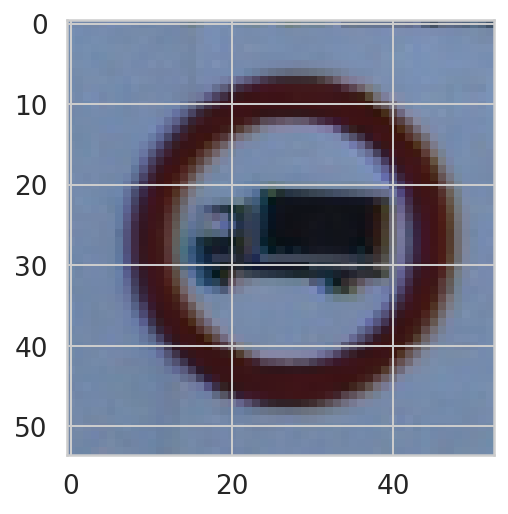

In [ ]:
sample_test = plt.imread('/content/GTSRB/Final_Test/Images/00000.ppm')
print(sample_test.shape)
rows,cols,colors = sample_test.shape # gives dimensions for RGB array
sample_test_size = rows*cols*colors
print(sample_test_size)
sample_test_1D_vector = sample_test.reshape(sample_test_size)
print(sample_test_1D_vector)
# you can recover the orginal image with:
sample_test2 = sample_test_1D_vector.reshape(rows,cols,colors)

plt.imshow(sample_test2)

### Preprocess images (read, resize, store)

In [ ]:
def img_preprocess(resize_dim = 32):
    
    # =========================== read train data ===========================
    num_classes = 43
    train_folder = '/content/GTSRB/Final_Training/Images'
    
    # sample counter
    num_sample = 0
    X_orig = []

    # outer-loop over class folders
    for i in range(num_classes):

        # get the collection of global image pathnames
        if i<10:
          tr_img_paths = np.array(glob( os.path.join(train_folder, "0000"+str(i)+"/*.ppm") ))
        else:
          tr_img_paths = np.array(glob( os.path.join(train_folder, "000"+str(i)+"/*.ppm") ))
        
        #print to monitor the progress
        #print(i)

        #lst_i stores all samples of class-i
        lst_i = []
        #r_sum, g_sum, b_sum = np.zeros(32*32), np.zeros(32*32), np.zeros(32*32)

        # iterate over samples of class-i
        for path in tr_img_paths:
            # read image from path, returns img_array/ndarray
            img = io.imread(path)   
            # resize
            img = transform.resize(img, (resize_dim,resize_dim))
            img_name = path.rsplit('/',1)[1]
            X_orig.append((img, i, img_name))

            num_sample += 1    


    # =========================== read test data ===========================
    #use 1st row as header/column names
    test_df = pd.read_csv('GTSRB/Final_Test/GT-final_test.csv', sep = ';', header = 0)

    test_orig = []
    # Source: https://stackoverflow.com/questions/1945920/why-doesnt-os-path-join-work-in-this-case
    test_folder = "/content/GTSRB/Final_Test/Images"
    test_img_paths = np.array(glob( os.path.join(test_folder, "*.ppm") ))

    #int(test_df.loc[test_df['Filename'] == "00000.ppm"]['ClassId'])
    
    for path in test_img_paths:

            img = io.imread(path)   
            #resize
            img = transform.resize(img, (resize_dim,resize_dim))
            img_name = path.rsplit('/',1)[1]
            img_label = int(test_df.loc[test_df['Filename'] == img_name]['ClassId']) 

            test_orig.append((img, img_label, img_name))

    
    return X_orig, num_sample, test_orig

## Read external images (Alto sign)

In [ ]:
signs_path = '/content/drive/MyDrive/CIS519 project/Alto_signs_resized'
acc = 0
loss = 0
test_alto = []
for file in os.listdir(signs_path):
  path = os.path.join(signs_path, file)
  img = io.imread(path)
  img = img.astype('d')
  test_alto.append((img, 14, 0))

### Read all images

In [ ]:
resize_dim = 32
X_orig, num_sample, test_orig = img_preprocess(resize_dim)

#### restore image from the rgb_vec, sample-0 
##### compare with the same image displayed above before resizing, the resized one seems to lose some color
 

Speed limit (20km/h)


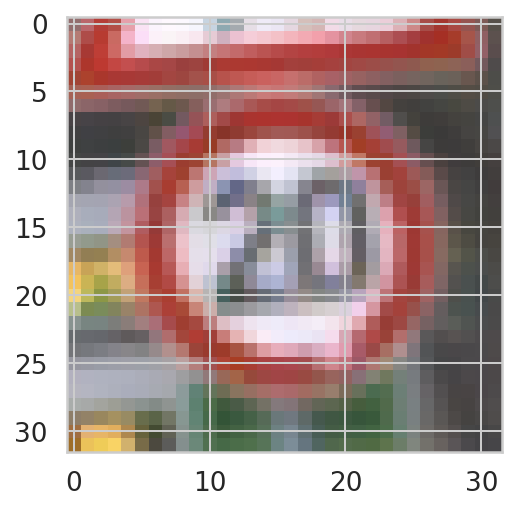

In [ ]:
# r_0, g_0, b_0 = X_rgb[0][0][:,0], X_rgb[0][0][:,1], X_rgb[0][0][:,2]
# stacked = np.dstack((r_0.reshape((resize_dim, resize_dim)),g_0.reshape((resize_dim, resize_dim)),b_0.reshape((resize_dim, resize_dim))))
# print(stacked.shape)
# plt.imshow(stacked.reshape((resize_dim, resize_dim, 3)))
print(classnames[X_orig[0][1]])
plt.imshow(X_orig[0][0])

No passing for vehicles over 3.5 metric tons


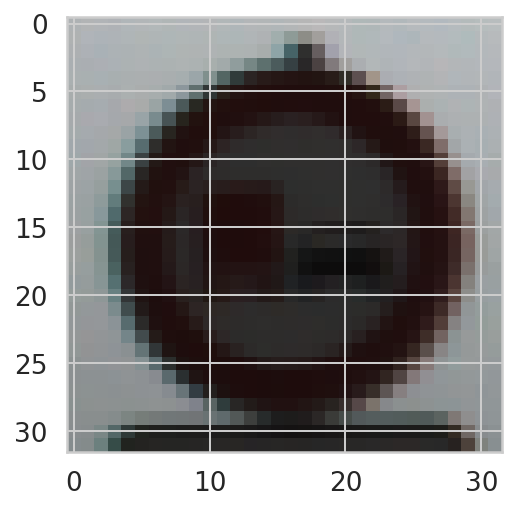

In [ ]:
# test
print(classnames[test_orig[0][1]])
plt.imshow(test_orig[0][0])

#### Implementation of PCA
##### Some sources: 
https://github.com/NourozR/Reconstruction-and-Compression-of-Color-Images/blob/master/image_reconstruction_using_PCA.py   
http://faculty.salina.k-state.edu/tim/DAT/_downloads/Principal_Component_Analysis_Tutorial.pdf

In [ ]:
def applyPCA(X_orig, n_components, pca_data=None):
    X_rgb = []

    for i in range(len(X_orig)):
        rgb_vec = X_orig[i][0].reshape(-1, 3)
        X_rgb.append(rgb_vec)

    r_mat, g_mat, b_mat = [], [], []

    # gather 3 matrics, for r,g,b vector of all samples
    for i in range(len(X_rgb)):
      r_mat.append(X_rgb[i][:,0])
      g_mat.append(X_rgb[i][:,1])
      b_mat.append(X_rgb[i][:,2])
      
    orig_rgb = [np.array(r_mat),np.array(g_mat),np.array(b_mat)]
    rgb_pca = []

    # apply PCA to train data
    if pca_data is None:
        pca_data = []

        for i in range(3):
            # mean_vec = mat.mean(0)
            # std_vec = mat.std(0)
            mat = orig_rgb[i]

            scaler = preprocessing.StandardScaler().fit(mat)
            
            mean_vec = scaler.mean_
            std_vec = np.sqrt(scaler.var_)
            mat_norm = scaler.transform(mat)

            pca = PCA(n_components**2)
            pca.fit(mat_norm)
            pc = pca.components_

            # store results of train data
            pca_data.append((mean_vec, std_vec, pc))

            #print(pca.explained_variance_ratio_)
            plt.plot(np.cumsum(pca.explained_variance_ratio_))
            plt.xlabel('number of components')
            plt.ylabel('cumulative explained variance')

            mat_pca = pca.transform(mat_norm)
            rgb_pca.append(mat_pca)


    # apply PCA to test_data
    else:
        for i in range(3):
            mat = orig_rgb[i]
            mean_vec, std_vec, pc = pca_data[i]

            mat_norm = (mat - mean_vec)/std_vec

            mat_pca = mat_norm.dot(pc.T)
            rgb_pca.append(mat_pca)



    # stack back to (h,w,c)
    X_pca = []

    for i in range(len(X_orig)):
        r_i, g_i, b_i = rgb_pca[0][i], rgb_pca[1][i], rgb_pca[2][i]
        stacked_i = np.dstack( (r_i.reshape((n_components, n_components)), g_i.reshape((n_components, n_components)), b_i.reshape((n_components, n_components))) )
        X_pca.append((stacked_i, X_orig[i][1], X_orig[i][2]))

    return X_pca, pca_data


###Segmentation methods

In [ ]:
import skimage.segmentation as seg
import skimage.color as color
import skimage.feature as feature
def seg_kmeans(img, n_segments):
  #Image segmentation with k-means
  image_slic = seg.slic(img, n_segments, multichannel=True, convert2lab=True)
  return image_slic
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray
def seg_edge(img, sigma, low_thresh = .1, high_thresh = 1):
    img = rgb2gray(img)
    image_edges = feature.canny(image=img, sigma=sigma, low_threshold=low_thresh,high_threshold=high_thresh)
    return image_edges

###Implementation of Segmentation

In [ ]:
def applyKmeans(X_orig, n_segments):
  X_kmeans = []
  for i in range(len(X_orig)):
    X_kmeans.append((seg_kmeans(X_orig[i][0], n_segments).reshape([32, 32, 1]).astype('d'), X_orig[i][1], X_orig[i][2]))
  return X_kmeans

def applyEdge(X_orig, sigma):
  X_edge = []
  for i in range(len(X_orig)):
    X_edge.append((seg_edge(X_orig[i][0], sigma).reshape([32, 32, 1]).astype('d'), X_orig[i][1], X_orig[i][2]))
  return X_edge


In [ ]:
class GtsrbDataset(Dataset):
    #lst is going to be X_orig/X_pca
    def __init__(self, lst, transform=None):
        self.lst = lst
        self.transform = transform

    def __len__(self):
        # len(dataset) returns the size of the dataset
        return len(self.lst)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.lst[idx][0]
        label = self.lst[idx][1]
        img_name = self.lst[idx][2]

        # peform image transformation:
        if self.transform is not None:
            # for some reason, it only works if *255 before transf, then /255 after transf
            image = image*255
            # convert ndarray to pil image for pytorch tranform to be applied
            img_pil = Image.fromarray(image.astype('uint8'), 'RGB')
            trsfm_img = img_pil
            # 
            for trsfm in self.transform:
                trsfm_img = trsfm(trsfm_img)
            #
            image = np.array(trsfm_img)/255
        
        image = torch.tensor(image)
      
        if len(image.shape)==3:
          # if using non-pca data, input image is already normalized to [0~1] during resize <-> [0~255]
          # HWC -> CHW (pytorch tensor default); e.g. pixel (2,3,c=1) -> (c=1,2,3)
          image = image.swapaxes(1,2).swapaxes(1,0)
       
        sample = (image, label)

        return sample

#Preprocessing transformations (PCA, kmeans,)

In [ ]:
apply_pca = False
apply_kmeans = False
apply_edge = False
external = False

X = copy.deepcopy(X_orig)
X_test = copy.deepcopy(test_orig)

if apply_pca:
  n_components = 16
  X_pca, pca_data = applyPCA(X_orig, n_components)
  test_pca, _ = applyPCA(test_orig, n_components, pca_data)

  X, X_test = copy.deepcopy(X_pca), copy.deepcopy(test_pca)

elif apply_kmeans:
  n_segments = 20
  X_kmeans = applyKmeans(X_orig, n_segments)
  test_kmeans = applyKmeans(test_orig, n_segments)
  X, X_test = copy.deepcopy(X_kmeans), copy.deepcopy(test_kmeans)

elif apply_edge:
  alpha = .25
  X_edge = applyEdge(X_orig, alpha)
  test_edge = applyEdge(test_orig, alpha)
  X, X_test = copy.deepcopy(X_edge), copy.deepcopy(test_edge)
  
elif external:
  X_test = copy.deepcopy(test_alto)

#### PCA exploratory section

In [ ]:
# #displays first 36 prinicipal components:

# pc = np.dstack( (pca_data[0][2][0,:].reshape((resize_dim, resize_dim)),pca_data[1][2][0,:].reshape((resize_dim, resize_dim)), pca_data[2][2][0,:].reshape((resize_dim, resize_dim))) )
# # plt.figure()
# # plt.title("component-"+str(1))
# # plt.imshow((pc-np.min(pc))/(np.max(pc)-np.min(pc)))

# pc_lst = [(pc-np.min(pc))/(np.max(pc)-np.min(pc))]

# for j in range(2,37,1):
#   pc = np.dstack( (pca_data[0][2][j,:].reshape((resize_dim, resize_dim)),pca_data[1][2][j,:].reshape((resize_dim, resize_dim)), pca_data[2][2][j,:].reshape((resize_dim, resize_dim))) )
#   # for i in range(1,j+1):
#   #   pc += np.dstack( (pca_data[0][2][i,:].reshape((resize_dim, resize_dim)),pca_data[1][2][i,:].reshape((resize_dim, resize_dim)), pca_data[2][2][i,:].reshape((resize_dim, resize_dim))) )
#   #print(str(j+1)+" components:")
#   # plt.figure()
#   # plt.title("component-"+str(j))
#   # plt.imshow((pc-np.min(pc))/(np.max(pc)-np.min(pc)))
#   pc_lst.append((pc-np.min(pc))/(np.max(pc)-np.min(pc)))

# import os
# import matplotlib.pyplot as plt
# import PIL
# %matplotlib inline

# rows = 6

# fig = plt.figure(figsize=(40, 40))

# for num, x in enumerate(pc_lst):
#     img = x
#     ax = fig.add_subplot(rows, 6, num+1)

#     plt.title("component-"+str(num+1))
#     plt.axis('off')
#     plt.imshow(img)



In [ ]:
# # displays reconstruction of i-th sample using principal components; currently displays using 300 components, step = 20
# sample_i = 16423
# X1 = X[sample_i][0]

# X1_rgb = X1.reshape(-1, 3)
# #a[xmin:xmax,ymin:ymax,:] = 0.

# for k in range(1, 300, 20):
#     X1_r, X1_g, X1_b = copy.deepcopy(X1_rgb[:,0]), copy.deepcopy(X1_rgb[:,1]), copy.deepcopy(X1_rgb[:,2])

#     X1_r[k:len(X1_r)] = 0
#     X1_g[k:len(X1_r)] = 0
#     X1_b[k:len(X1_r)] = 0

#     X1_rc, X1_gc, X1_bc = (pca_data[0][2].T).dot(X1_r), (pca_data[1][2].T).dot(X1_g), (pca_data[2][2].T).dot(X1_b) 
#     X1_stacked = np.dstack( (X1_rc.reshape((resize_dim, resize_dim)), X1_gc.reshape((resize_dim, resize_dim)), X1_bc.reshape((resize_dim, resize_dim))) )

#     plt.figure()
#     plt.title(str(k)+" components:")
#     plt.imshow((X1_stacked-np.min(X1_stacked))/(np.max(X1_stacked)-np.min(X1_stacked)))

#### Shuffle the X data
#### Source:
https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

###Split dataloader into training and testing



In [ ]:

# shuffle input data (optional, since the dataloader already has shuffle = True)
random.Random(RANDOM_SEED).shuffle(X)
random.Random(RANDOM_SEED).shuffle(X_test)

#data_transforms = None 

# Not used since no noticable improvements was noticed for training
# tr_transform = [
#   #0~30 deg
#   T.RandomRotation((0,30)),
#   #0.3 chance to flip
#   T.RandomHorizontalFlip(0.3)
# ]

# # Should same transform of train be applied to test? It seems that if apply no transf to test, the test acc will be low
# test_transform = [
#   #0~30 deg
#   T.RandomRotation((0,30)),
#   #0.3 chance to flip
#   T.RandomHorizontalFlip(0.3)
# ]

tr_transform = None
test_transform = None

gtsrb_dataset = GtsrbDataset(X, tr_transform)

test_dataset = GtsrbDataset(X_test, test_transform)

val_split = 0.2

batch_size_train = 100
batch_size_test = 1
shuffle_dataset = True
random_seed= 42
num_workers = 2

# Creating data indices for training and validation splits:
dataset_size = len(gtsrb_dataset)
indices = list(range(dataset_size))
split = int(np.floor(val_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

print("training samples:", dataset_size-split)
print("validation samples:", split)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

tr_loader = torch.utils.data.DataLoader(gtsrb_dataset, batch_size=batch_size_train,   
                                           sampler=train_sampler, num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(gtsrb_dataset, batch_size=batch_size_test,
                                                sampler=valid_sampler, num_workers=num_workers)

# Create test dataloader:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, num_workers=num_workers)
print("test samples:", len(test_loader))

training samples: 31368
validation samples: 7841
test samples: 12630


#### display 4 batches of tr_loader

torch.Size([1, 3, 32, 32])


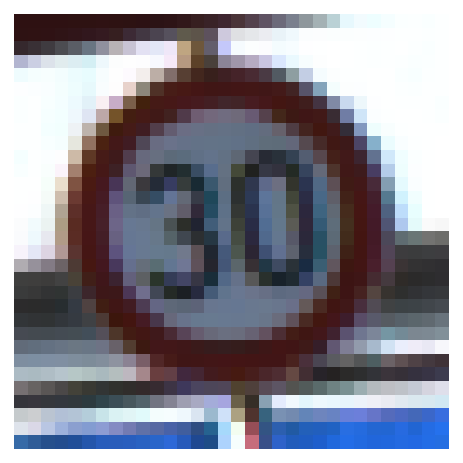

torch.Size([1, 3, 32, 32])


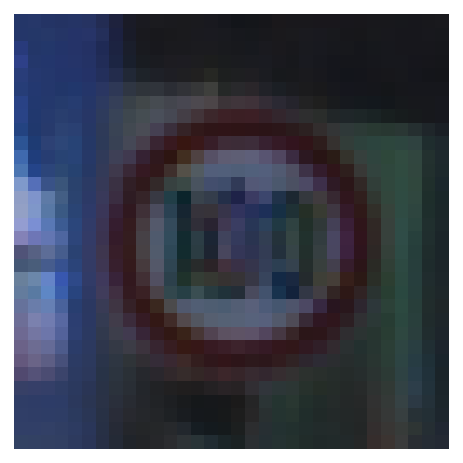

torch.Size([1, 3, 32, 32])


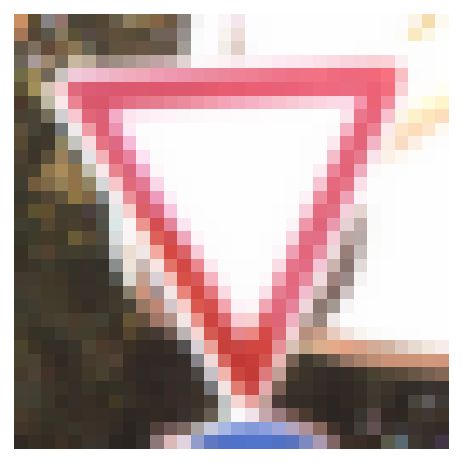

torch.Size([1, 3, 32, 32])


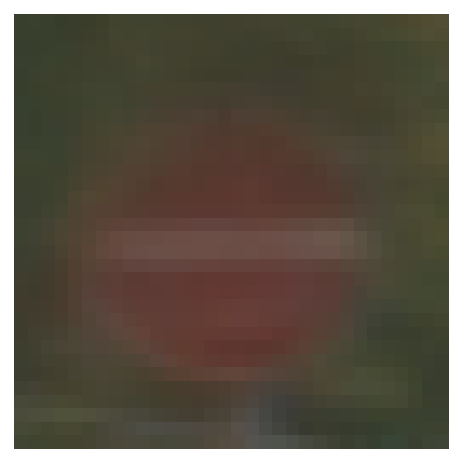

In [ ]:
from torchvision import transforms, utils

def display_batch(sample_batched):
    images_batch = sample_batched[0]
    print(images_batch.shape)
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


for i_batch, sample_batched in enumerate(test_loader):
    plt.figure()
    display_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()

    # observe 4th batch and stop.
    if i_batch == 3:
        break

#Hyperparameters

In [ ]:
class Args(object):
  learning_rate = .0001
  weight_decay = 0.035
  log_dir = 'tb_dir'
  epsilon = .0000001

args = Args();

#Loss

In [ ]:
criterion = nn.CrossEntropyLoss()

#CNN architecture definition

##Weight Initialization

#### Weight initialization function from homework 4 skeleton

In [ ]:
#Weight initialization from homework 4 skeleton

def init_weights(net):
    """
    Usage: net = Model()
           net.apply(init_weights)
    """
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

##  Models
##### Homework 4's template helped provide a template for building CNN models

In [ ]:
from torchsummary import summary

###CNN1

In [ ]:
class cnn1(torch.nn.Module):
    def __init__(self):
      super(cnn1, self).__init__() 
      self.conv_1 = nn.Conv2d(in_channels=3, out_channels= 27, kernel_size = 4, stride= 1, padding = 1, bias = True)
      self.pool = nn.MaxPool2d(kernel_size = 2, stride = 1)
      self.conv_2 = nn.Conv2d(in_channels=27, out_channels= 73, kernel_size = 4, stride= 1, padding = 0, bias = True)
      self.conv_3 = nn.Conv2d(in_channels=73, out_channels= 110, kernel_size = 4, stride= 1, padding = 0, bias = True)
      self.conv_4 = nn.Conv2d(in_channels=110, out_channels= 55, kernel_size = 4, stride= 1, padding = 0, bias = True)
      self.conv_5 = nn.Conv2d(in_channels=55, out_channels= 12, kernel_size = 4, stride= 1, padding = 0, bias = True)
      self.linear_1 = nn.Linear(in_features = 3072, out_features=300, bias = True)
      self.linear_2 = nn.Linear(in_features = 300, out_features= 43, bias = True)
      self.relu = nn.ReLU()
    
    def forward(self, x):
      x = self.relu(self.conv_1(x))
      x = self.pool(x)
      x = self.relu(self.conv_2(x))
      x = self.pool(x)
      x = self.relu(self.conv_3(x))
      x = self.relu(self.conv_4(x))
      x = self.relu(self.conv_5(x))
      x = self.pool(x)
      x = x.reshape(x.size(0), -1)
      x = self.relu(self.linear_1(x))
      x = self.linear_2(x)
      return x
cnn_model1 = cnn1()
cnn_model1.to(device)


cnn1(
  (conv_1): Conv2d(3, 27, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(27, 73, kernel_size=(4, 4), stride=(1, 1))
  (conv_3): Conv2d(73, 110, kernel_size=(4, 4), stride=(1, 1))
  (conv_4): Conv2d(110, 55, kernel_size=(4, 4), stride=(1, 1))
  (conv_5): Conv2d(55, 12, kernel_size=(4, 4), stride=(1, 1))
  (linear_1): Linear(in_features=3072, out_features=300, bias=True)
  (linear_2): Linear(in_features=300, out_features=43, bias=True)
  (relu): ReLU()
)

In [ ]:

summary(cnn_model1.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 27, 31, 31]           1,323
              ReLU-2           [-1, 27, 31, 31]               0
         MaxPool2d-3           [-1, 27, 30, 30]               0
            Conv2d-4           [-1, 73, 27, 27]          31,609
              ReLU-5           [-1, 73, 27, 27]               0
         MaxPool2d-6           [-1, 73, 26, 26]               0
            Conv2d-7          [-1, 110, 23, 23]         128,590
              ReLU-8          [-1, 110, 23, 23]               0
            Conv2d-9           [-1, 55, 20, 20]          96,855
             ReLU-10           [-1, 55, 20, 20]               0
           Conv2d-11           [-1, 12, 17, 17]          10,572
             ReLU-12           [-1, 12, 17, 17]               0
        MaxPool2d-13           [-1, 12, 16, 16]               0
           Linear-14                  [

###CNN2

In [ ]:
class cnn2(torch.nn.Module):
    def __init__(self):
        super(cnn2, self).__init__() 
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels= 27, kernel_size = 4, stride= 1, padding = 1, bias = True)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 1)
        self.conv_2 = nn.Conv2d(in_channels=27, out_channels= 73, kernel_size = 4, stride= 1, padding = 0, bias = True)
        self.conv_3 = nn.Conv2d(in_channels=73, out_channels= 110, kernel_size = 4, stride= 1, padding = 0, bias = True)
        self.conv_4 = nn.Conv2d(in_channels=110, out_channels= 55, kernel_size = 4, stride= 1, padding = 0, bias = True)
        self.conv_5 = nn.Conv2d(in_channels=55, out_channels= 12, kernel_size = 4, stride= 1, padding = 0, bias = True)
        self.linear_1 = nn.Linear(in_features = 3072, out_features= 4000, bias = True)
        self.linear_2 = nn.Linear(in_features = 4000, out_features= 43, bias = True)
        self.relu = nn.ReLU()      

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.pool(x)
        x = self.relu(self.conv_2(x))
        x = self.pool(x)
        x = self.relu(self.conv_3(x))
        x = self.relu(self.conv_4(x))
        x = self.relu(self.conv_5(x))
        x = self.pool(x)
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.linear_1(x))
        x = self.relu(self.linear_2(x))
        return x
cnn_model3 = cnn2()
cnn_model2.to(device)

cnn3(
  (conv_1): Conv2d(3, 27, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(27, 73, kernel_size=(4, 4), stride=(1, 1))
  (conv_3): Conv2d(73, 110, kernel_size=(4, 4), stride=(1, 1))
  (conv_4): Conv2d(110, 55, kernel_size=(4, 4), stride=(1, 1))
  (conv_5): Conv2d(55, 12, kernel_size=(4, 4), stride=(1, 1))
  (linear_1): Linear(in_features=3072, out_features=4000, bias=True)
  (linear_2): Linear(in_features=4000, out_features=43, bias=True)
  (linear_3): Linear(in_features=128, out_features=6, bias=True)
  (relu): ReLU()
)

In [ ]:
summary(cnn_model2.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 27, 31, 31]           1,323
              ReLU-2           [-1, 27, 31, 31]               0
         MaxPool2d-3           [-1, 27, 30, 30]               0
            Conv2d-4           [-1, 73, 27, 27]          31,609
              ReLU-5           [-1, 73, 27, 27]               0
         MaxPool2d-6           [-1, 73, 26, 26]               0
            Conv2d-7          [-1, 110, 23, 23]         128,590
              ReLU-8          [-1, 110, 23, 23]               0
            Conv2d-9           [-1, 55, 20, 20]          96,855
             ReLU-10           [-1, 55, 20, 20]               0
           Conv2d-11           [-1, 12, 17, 17]          10,572
             ReLU-12           [-1, 12, 17, 17]               0
        MaxPool2d-13           [-1, 12, 16, 16]               0
           Linear-14                 [-

In [ ]:
summary(cnn_model2.to(device), (3, 32, 32))

###CNN3

In [ ]:
class cnn3(torch.nn.Module):
    def __init__(self):
      super(cnn3, self).__init__() 
      self.conv_1 = nn.Conv2d(in_channels=3, out_channels= 27, kernel_size = 4, stride= 1, padding = 1, bias = True)
      self.pool = nn.MaxPool2d(kernel_size = 2, stride = 1)
      self.conv_2 = nn.Conv2d(in_channels=27, out_channels= 73, kernel_size = 4, stride= 1, padding = 0, bias = True)
      self.conv_3 = nn.Conv2d(in_channels=73, out_channels= 110, kernel_size = 4, stride= 1, padding = 0, bias = True)
      self.conv_4 = nn.Conv2d(in_channels=110, out_channels= 55, kernel_size = 4, stride= 1, padding = 0, bias = True)
      self.conv_5 = nn.Conv2d(in_channels=55, out_channels= 12, kernel_size = 4, stride= 1, padding = 0, bias = True)
      self.linear_1 = nn.Linear(in_features = 3072, out_features=1000, bias = True)
      self.linear_2 = nn.Linear(in_features = 1000, out_features= 43, bias = True)
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout2d()
    
    def forward(self, x):
      x = self.relu(self.conv_1(x))
      x = self.pool(x)
      x = self.relu(self.conv_2(x))
      x = self.pool(x)
      x = self.relu(self.conv_3(x))
      x = self.relu(self.conv_4(x))
      x = self.relu(self.conv_5(x))
      x = self.pool(x)
      x = x.reshape(x.size(0), -1)
      x = self.relu(self.linear_1(x))
      x = self.dropout(x)
      x = self.linear_2(x)
      return x
cnn_model3 = cnn3()
cnn_model3.to(device)

cnn3(
  (conv_1): Conv2d(3, 27, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(27, 73, kernel_size=(4, 4), stride=(1, 1))
  (conv_3): Conv2d(73, 110, kernel_size=(4, 4), stride=(1, 1))
  (conv_4): Conv2d(110, 55, kernel_size=(4, 4), stride=(1, 1))
  (conv_5): Conv2d(55, 12, kernel_size=(4, 4), stride=(1, 1))
  (linear_1): Linear(in_features=3072, out_features=1000, bias=True)
  (linear_2): Linear(in_features=1000, out_features=43, bias=True)
  (relu): ReLU()
  (dropout): Dropout2d(p=0.5, inplace=False)
)

In [ ]:
summary(cnn_model3.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 27, 31, 31]           1,323
              ReLU-2           [-1, 27, 31, 31]               0
         MaxPool2d-3           [-1, 27, 30, 30]               0
            Conv2d-4           [-1, 73, 27, 27]          31,609
              ReLU-5           [-1, 73, 27, 27]               0
         MaxPool2d-6           [-1, 73, 26, 26]               0
            Conv2d-7          [-1, 110, 23, 23]         128,590
              ReLU-8          [-1, 110, 23, 23]               0
            Conv2d-9           [-1, 55, 20, 20]          96,855
             ReLU-10           [-1, 55, 20, 20]               0
           Conv2d-11           [-1, 12, 17, 17]          10,572
             ReLU-12           [-1, 12, 17, 17]               0
        MaxPool2d-13           [-1, 12, 16, 16]               0
           Linear-14                 [-

###CNN4

In [ ]:
class cnn4(torch.nn.Module):
    def __init__(self):
      super(cnn4, self).__init__() 
      self.conv_1 = nn.Conv2d(in_channels=3, out_channels= 27, kernel_size = 4, stride= 1, padding = 1, bias = True)
      self.pool = nn.MaxPool2d(kernel_size = 2, stride = 1)
      self.conv_2 = nn.Conv2d(in_channels=27, out_channels= 73, kernel_size = 4, stride= 1, padding = 0, bias = True)
      self.conv_3 = nn.Conv2d(in_channels=73, out_channels= 110, kernel_size = 4, stride= 1, padding = 0, bias = True)
      self.conv_4 = nn.Conv2d(in_channels=110, out_channels= 55, kernel_size = 4, stride= 1, padding = 0, bias = True)
      self.conv_5 = nn.Conv2d(in_channels=55, out_channels= 12, kernel_size = 4, stride= 1, padding = 0, bias = True)
      self.linear_1 = nn.Linear(in_features = 3072, out_features=2000, bias = True)
      self.linear_2 = nn.Linear(in_features = 2000, out_features= 43, bias = True)
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout2d()
    
    def forward(self, x):
      x = self.relu(self.conv_1(x))
      x = self.pool(x)
      x = self.relu(self.conv_2(x))
      x = self.pool(x)
      x = self.relu(self.conv_3(x))
      x = self.relu(self.conv_4(x))
      x = self.relu(self.conv_5(x))
      x = self.pool(x)
      x = x.reshape(x.size(0), -1)
      x = self.dropout(x)
      x = self.relu(self.linear_1(x))
      x = self.dropout(x)
      x = self.linear_2(x)
      return x
cnn_model4 = cnn4()
cnn_model4.to(device)

cnn4(
  (conv_1): Conv2d(3, 27, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(27, 73, kernel_size=(4, 4), stride=(1, 1))
  (conv_3): Conv2d(73, 110, kernel_size=(4, 4), stride=(1, 1))
  (conv_4): Conv2d(110, 55, kernel_size=(4, 4), stride=(1, 1))
  (conv_5): Conv2d(55, 12, kernel_size=(4, 4), stride=(1, 1))
  (linear_1): Linear(in_features=3072, out_features=2000, bias=True)
  (linear_2): Linear(in_features=2000, out_features=43, bias=True)
  (relu): ReLU()
  (dropout): Dropout2d(p=0.5, inplace=False)
)

In [ ]:
summary(cnn_model4.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 27, 31, 31]           1,323
              ReLU-2           [-1, 27, 31, 31]               0
         MaxPool2d-3           [-1, 27, 30, 30]               0
            Conv2d-4           [-1, 73, 27, 27]          31,609
              ReLU-5           [-1, 73, 27, 27]               0
         MaxPool2d-6           [-1, 73, 26, 26]               0
            Conv2d-7          [-1, 110, 23, 23]         128,590
              ReLU-8          [-1, 110, 23, 23]               0
            Conv2d-9           [-1, 55, 20, 20]          96,855
             ReLU-10           [-1, 55, 20, 20]               0
           Conv2d-11           [-1, 12, 17, 17]          10,572
             ReLU-12           [-1, 12, 17, 17]               0
        MaxPool2d-13           [-1, 12, 16, 16]               0
        Dropout2d-14                 [-

###CNN5

In [ ]:
class cnn5(torch.nn.Module):
    def __init__(self):
      super(cnn5, self).__init__() 
      self.conv_1 = nn.Conv2d(in_channels=1, out_channels= 27, kernel_size = 4, stride= 1, padding = 1, bias = True)
      self.pool = nn.MaxPool2d(kernel_size = 2, stride = 1)
      self.conv_2 = nn.Conv2d(in_channels=27, out_channels= 73, kernel_size = 4, stride= 1, padding = 0, bias = True)
      self.conv_3 = nn.Conv2d(in_channels=73, out_channels= 110, kernel_size = 4, stride= 1, padding = 0, bias = True)
      self.conv_4 = nn.Conv2d(in_channels=110, out_channels= 55, kernel_size = 4, stride= 1, padding = 0, bias = True)
      self.conv_5 = nn.Conv2d(in_channels=55, out_channels= 12, kernel_size = 4, stride= 1, padding = 0, bias = True)
      self.linear_1 = nn.Linear(in_features = 3072, out_features=2000, bias = True)
      self.linear_2 = nn.Linear(in_features = 2000, out_features= 43, bias = True)
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout2d()
    
    def forward(self, x):
      x = self.relu(self.conv_1(x))
      x = self.pool(x)
      x = self.relu(self.conv_2(x))
      x = self.pool(x)
      x = self.relu(self.conv_3(x))
      x = self.relu(self.conv_4(x))
      x = self.relu(self.conv_5(x))
      x = self.pool(x)
      x = x.reshape(x.size(0), -1)
      x = self.dropout(x)
      x = self.relu(self.linear_1(x))
      x = self.dropout(x)
      x = self.linear_2(x)
      return x
cnn_model5 = cnn5()
cnn_model5.to(device)

In [ ]:
summary(cnn_model5.to(device), (1, 32, 32))

###CNN-PCA (resize=48, n_components=24)

In [ ]:
# class cnn_pca(torch.nn.Module):
#     def __init__(self):
#       super(cnn4, self).__init__() 
#       self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=1)
#       self.conv1 = torch.nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1, bias=True)
#       self.conv2 = torch.nn.Conv2d(in_channels=64,out_channels=110,kernel_size=4,stride=2,padding=1, bias=True)
#       self.conv3 = torch.nn.Conv2d(in_channels=110,out_channels=128,kernel_size=4,stride=2,padding=1, bias=True)
#       self.dropout = torch.nn.Dropout(p=0.5)
#       self.relu = torch.nn.ReLU(inplace=False)
#       self.linear1 = torch.nn.Linear(in_features=3200, out_features=2000, bias=True)
#       self.linear2 = torch.nn.Linear(in_features=2000, out_features=512, bias=True)
#       self.linear3 = torch.nn.Linear(in_features=512, out_features=43, bias=True)        

#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         x = self.relu(self.conv2(x))
#         x = self.dropout(x)
#         x = self.relu(self.conv3(x))
#         x = self.dropout(x)
#         x = self.pool(x)
#         x = x.reshape(x.size(0), -1)
#         #print("size of x is {}".format(x.size(1)))
#         x = self.relu(self.linear1(x))
#         x = self.dropout(x)
#         x = self.relu(self.linear2(x))
#         #x = self.dropout(x)
#         x = self.linear3(x)
#         return x
# cnn_model_pca = cnn_pca()
# cnn_model_pca.to(device)

#Save model functions

In [ ]:
from torch import save
from torch import load
from os import path
def save_model(model, name):
  return save(model.state_dict(), name + ".pth")

#Train

In [ ]:
import math 

def train_cnn(model, optimizer, criterion, epochs=10):
    for child in model.children():
      if hasattr(child, 'reset_parameters'):
        child.reset_parameters()
    model = model.double()
    model.train()
    model.to(device)
    running_loss = 0.0
    loss_epoch = []
    acc_epoch = []
    global_acc = 0
    acc = 0
    batch_size = 0
    for epoch in range(epochs):
      for i, data in enumerate(tr_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        y_pred = torch.argmax(outputs, dim = 1)
        loss = criterion(outputs, labels)
        acc = torch.sum(y_pred == labels)/len(labels)
        global_acc += acc.tolist()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i == 0:
          batch_size = len(labels)
      print('epoch: %d, acc: %.3f, loss: %.3f' %(epoch, global_acc/math.ceil(len(train_sampler)/batch_size), running_loss))
      loss_epoch.append(running_loss)
      acc_epoch.append(global_acc/math.ceil(len(train_sampler)/batch_size))
      running_loss = 0.0
      global_acc = 0


    final_training_accuracy = acc_epoch[-1]
    final_training_loss = loss_epoch[-1]
    return final_training_loss, final_training_accuracy, loss_epoch, acc_epoch

##Train CNN1

In [ ]:
cnn1_epochs = 5
cnn1_optimizer = torch.optim.Adam(cnn_model1.parameters(), lr=args.learning_rate)                  
cnn1_training_loss, cnn1_training_accuracy, loss1_list, accuracy1_list = train_cnn(cnn_model1, cnn1_optimizer, criterion, cnn1_epochs)

epoch: 0, acc: 0.276, loss: 849.578
epoch: 1, acc: 0.873, loss: 150.525
epoch: 2, acc: 0.941, loss: 71.739
epoch: 3, acc: 0.964, loss: 44.460
epoch: 4, acc: 0.975, loss: 31.765


In [ ]:
cnn1_epochs = 6
cnn1_optimizer = torch.optim.Adam(cnn_model1.parameters(), lr=args.learning_rate)                  
cnn1_training_loss, cnn1_training_accuracy, loss1_list, accuracy1_list = train_cnn(cnn_model1, cnn1_optimizer, criterion, cnn1_epochs)

epoch: 0, acc: 0.306, loss: 820.327
epoch: 1, acc: 0.862, loss: 161.701
epoch: 2, acc: 0.933, loss: 79.584
epoch: 3, acc: 0.957, loss: 51.355
epoch: 4, acc: 0.970, loss: 36.267
epoch: 5, acc: 0.977, loss: 27.350


Text(0, 0.5, 'Accuracy')

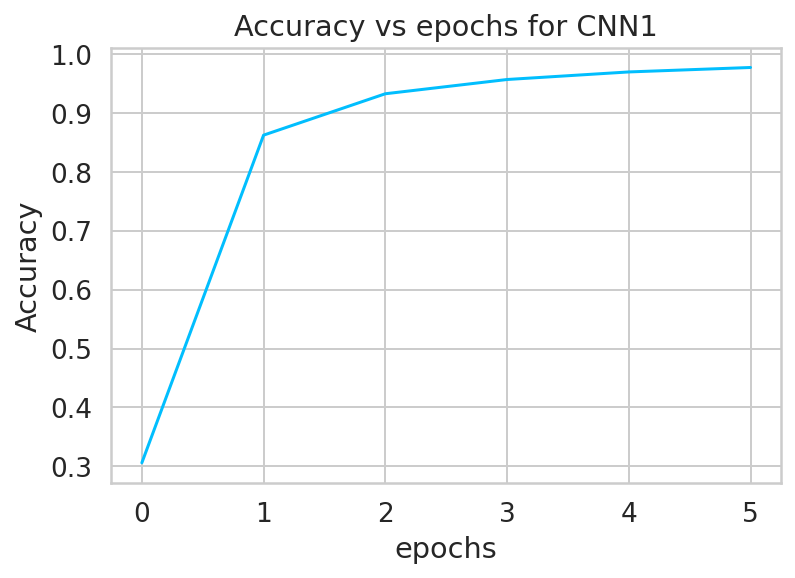

In [ ]:
plt.plot(accuracy1_list)
plt.title("Accuracy vs epochs for CNN1")
plt.xlabel("epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

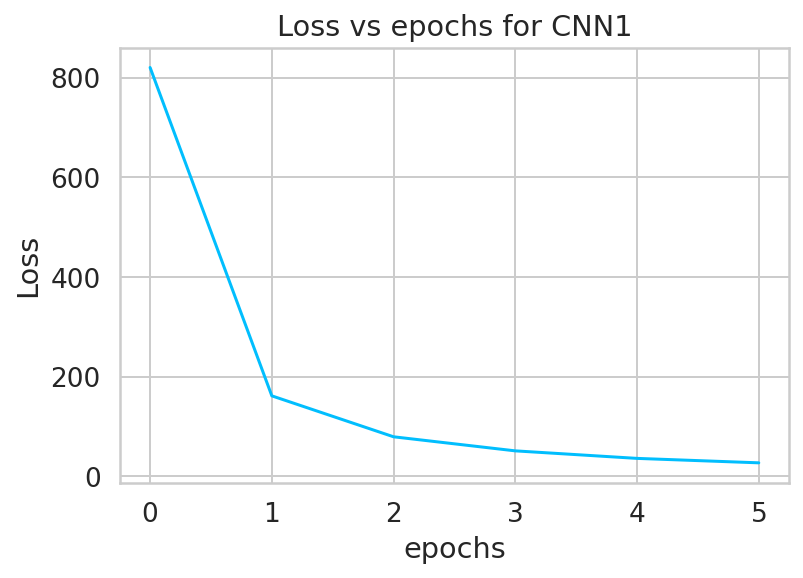

In [ ]:
plt.plot(loss1_list)
plt.title("Loss vs epochs for CNN1")
plt.xlabel("epochs")
plt.ylabel("Loss")

##Train CNN2

In [ ]:
cnn2_epochs = 9
cnn_model2.apply(init_weights)
cnn2_optimizer = torch.optim.Adam(cnn_model2.parameters(), lr=args.learning_rate)                  
cnn2_training_loss, cnn2_training_accuracy, loss2_list, accuracy2_list = train_cnn(cnn_model2, cnn2_optimizer, criterion, cnn2_epochs)

epoch: 0, acc: 0.245, loss: 968.095
epoch: 1, acc: 0.388, loss: 764.964
epoch: 2, acc: 0.399, loss: 734.249
epoch: 3, acc: 0.405, loss: 721.179
epoch: 4, acc: 0.406, loss: 714.638
epoch: 5, acc: 0.408, loss: 711.022
epoch: 6, acc: 0.409, loss: 708.722
epoch: 7, acc: 0.410, loss: 705.940
epoch: 8, acc: 0.411, loss: 705.239


Text(0, 0.5, 'Accuracy')

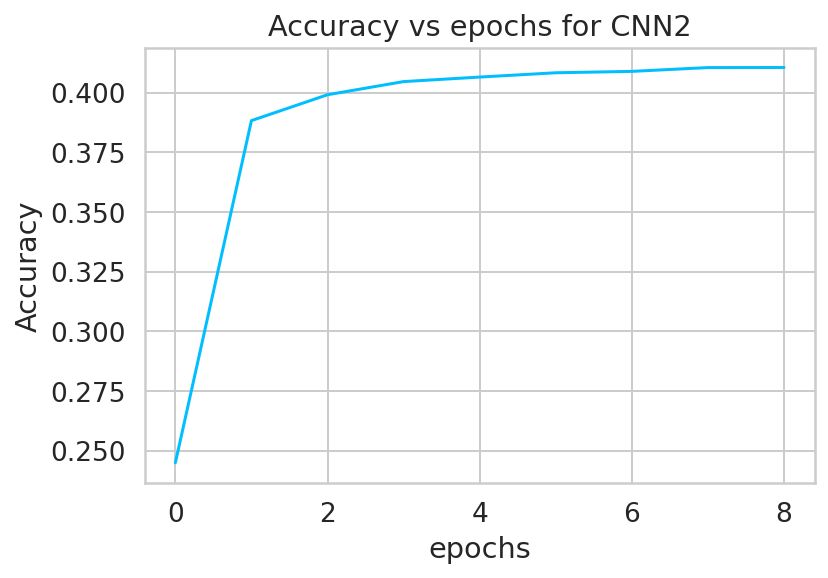

In [ ]:
plt.plot(accuracy2_list)
plt.title("Accuracy vs epochs for CNN2")
plt.xlabel("epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

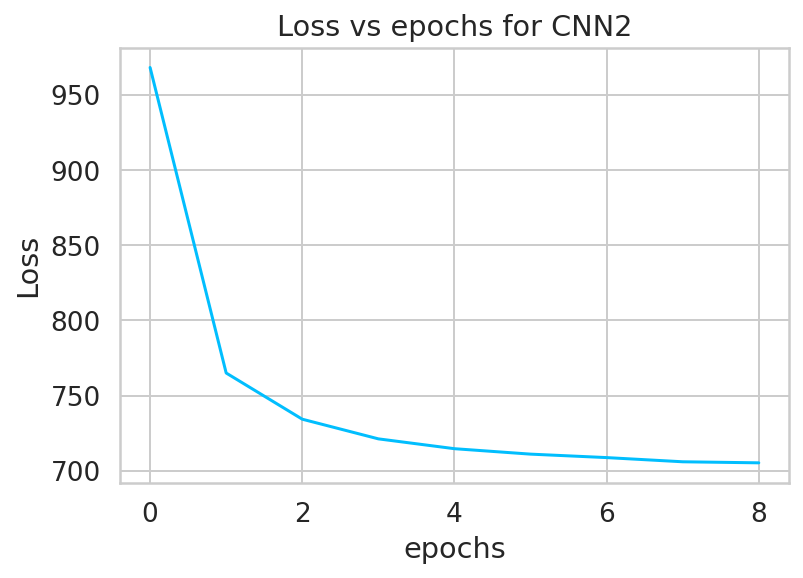

In [ ]:
plt.plot(loss2_list)
plt.title("Loss vs epochs for CNN2")
plt.xlabel("epochs")
plt.ylabel("Loss")

##Train CNN3


In [ ]:
cnn3_epochs = 10
#cnn_model2.apply(init_weights)
cnn3_optimizer = torch.optim.Adam(cnn_model3.parameters(), lr=args.learning_rate)                  
cnn3_training_loss, cnn3_training_accuracy, loss3_list, accuracy3_list = train_cnn(cnn_model3, cnn3_optimizer, criterion, cnn3_epochs)

epoch: 0, acc: 0.210, loss: 916.831
epoch: 1, acc: 0.751, loss: 258.920
epoch: 2, acc: 0.895, loss: 110.377
epoch: 3, acc: 0.936, loss: 69.642
epoch: 4, acc: 0.956, loss: 48.060
epoch: 5, acc: 0.967, loss: 35.257
epoch: 6, acc: 0.973, loss: 27.271
epoch: 7, acc: 0.979, loss: 22.998
epoch: 8, acc: 0.983, loss: 17.464
epoch: 9, acc: 0.984, loss: 16.603


Text(0, 0.5, 'Accuracy')

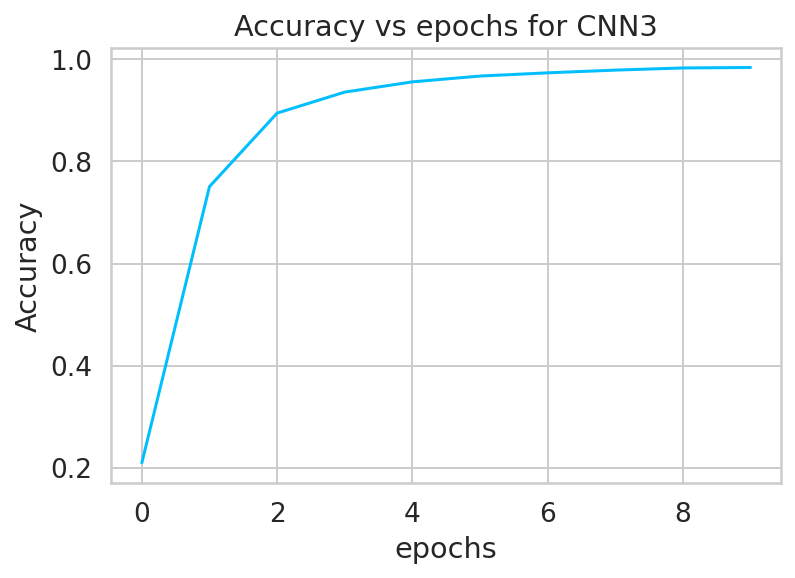

In [ ]:
plt.plot(accuracy3_list)
plt.title("Accuracy vs epochs for CNN3")
plt.xlabel("epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

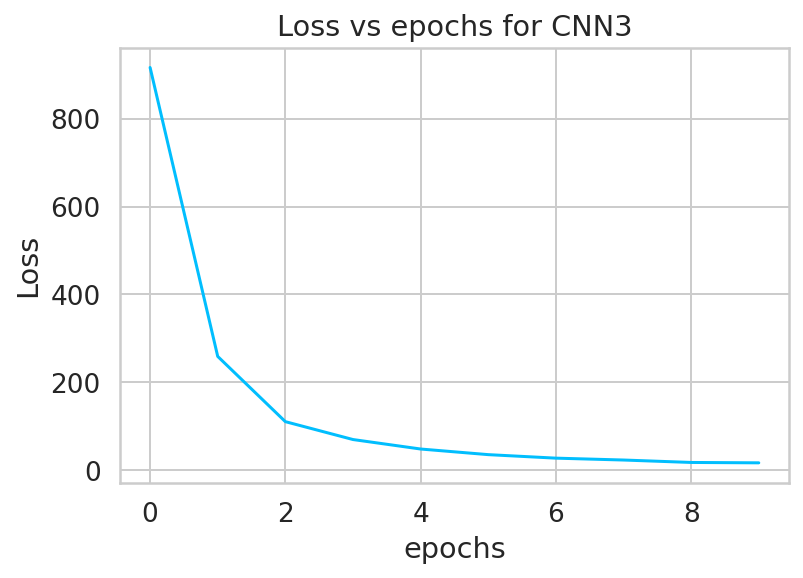

In [ ]:
plt.plot(loss3_list)
plt.title("Loss vs epochs for CNN3")
plt.xlabel("epochs")
plt.ylabel("Loss")

In [ ]:
save_model(cnn_model3, "CNN3") 

##Train CNN4


In [ ]:
cnn4_epochs = 18
#cnn_model2.apply(init_weights)
cnn4_optimizer = torch.optim.Adam(cnn_model4.parameters(), lr=args.learning_rate)                  
cnn4_training_loss, cnn4_training_accuracy, loss4_list, accuracy4_list = train_cnn(cnn_model4, cnn4_optimizer, criterion, cnn4_epochs)

epoch: 0, acc: 0.335, loss: 767.477
epoch: 1, acc: 0.838, loss: 171.050
epoch: 2, acc: 0.919, loss: 88.510
epoch: 3, acc: 0.945, loss: 58.449
epoch: 4, acc: 0.961, loss: 42.439
epoch: 5, acc: 0.970, loss: 32.698
epoch: 6, acc: 0.975, loss: 26.430


In [ ]:
save_model(cnn_model4, "CNN4") 

##Train CNN5

In [ ]:
cnn5_epochs = 18
#cnn_model2.apply(init_weights)
cnn5_optimizer = torch.optim.Adam(cnn_model5.parameters(), lr=args.learning_rate)                  
cnn5_training_loss, cnn5_training_accuracy, loss5_list, accuracy5_list = train_cnn(cnn_model5, cnn5_optimizer, criterion, cnn5_epochs)

In [ ]:
plt.plot(accuracy5_list)
plt.title("Accuracy vs epochs for CNN5")
plt.xlabel("epochs")
plt.ylabel("Accuracy")

In [ ]:
plt.plot(loss5_list)
plt.title("Loss vs epochs for CNN5")
plt.xlabel("epochs")
plt.ylabel("Loss")

#Test

In [ ]:
#To use test loader
total = len(test_loader)

In [ ]:
#To use valid loader
total = len(val_loader)

In [ ]:
#To get distribution of test samples and misclassified samples
missclassified = {}
distribution_test = {}
for clas in classnames:
  missclassified[clas] = 0
  distribution_test[clas] = 0

In [ ]:
def test_cnn(model, criterion):
    
    model.eval()
    model = model.to(device)
    global_loss = 0.0
    global_acc = 0.0
    #Change to test_loader for test set and val_loader for validation set
    for i, data in enumerate(test_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)
      outputs = model(inputs)
      y_pred = torch.argmax(outputs, dim = 1)
      loss = criterion(outputs, labels)
      acc = torch.sum(y_pred == labels)/len(labels)
      ###THIS PART OF THE CODE ASSUMES THAT BATCH_SIZE TEST IS 1###
      distribution_test[classnames[labels.item()]] = distribution_test[classnames[labels.item()]] + 1
      if y_pred != labels:
        missclassified[classnames[labels.item()]] = missclassified[classnames[labels.item()]] + 1

      global_loss+= loss.item()
      global_acc += acc.item() 


    testing_loss = global_loss        
    testing_accuracy = global_acc / (total/batch_size_test)  
    return  testing_loss, testing_accuracy

##Test CNN1

In [ ]:
cnn1_testing_loss, cnn1_testing_accuracy = test_cnn(cnn_model1, criterion)
cnn1_testing_loss, cnn1_testing_accuracy

(885.0416392607633, 0.9764060706542533)

##Test CNN2

In [ ]:
cnn2_testing_loss, cnn2_testing_accuracy = test_cnn(cnn_model2, criterion)
cnn2_testing_loss, cnn2_testing_accuracy

##Test CNN3

In [ ]:
cnn3_testing_loss, cnn3_testing_accuracy = test_cnn(cnn_model3, criterion)
cnn3_testing_loss, cnn3_testing_accuracy

(388.8016006158333, 0.9890320112230583)

##Test CNN4

In [ ]:
cnn4_testing_loss, cnn4_testing_accuracy = test_cnn(cnn_model4, criterion)
cnn4_testing_loss, cnn4_testing_accuracy

(256.226007799164, 0.9920928453003444)

##Test CNN5

In [ ]:
cnn5_testing_loss, cnn5_testing_accuracy = test_cnn(cnn_model5, criterion)
cnn5_testing_loss, cnn5_testing_accuracy

##Calculate percentage misclassified by class

In [ ]:
missclassified_percent = {}
for clas in missclassified.keys():
  missclassified_percent[clas] = missclassified[clas] / distribution_test[clas] * 100

In [ ]:
#Sort both dictionaries
sorted_missclas_percent = dict(sorted(missclassified_percent.items(), key=lambda kv: kv[1], reverse=True))
sorted_distribution_test = dict(sorted(distribution_test.items(), key=lambda kv: kv[1], reverse=True))

In [ ]:
#plot
plt.figure(figsize=(20, 3)) 
plt.bar(sorted_distribution_test.keys(), sorted_distribution_test.values(), align='edge', width=0.3)
plt.xticks(pos, sorted_distribution_test.keys(), rotation='vertical')
plt.title("Distribution of test samples")
plt.ylabel("Number of Test samples")

In [ ]:
plt.figure(figsize=(20, 3)) 
plt.bar(sorted_missclas_percent.keys(), sorted_missclas_percent.values(), align='edge', width=0.3)
plt.xticks(pos, sorted_missclas_percent.keys(), rotation='vertical')
plt.title("Misclassified distribution")
plt.ylabel("% Test samples misclassified")

#Plot weights of Convolutional layers
#### Used the below link/code to experiment on possibly viewing patterns picked up by layers
https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e
https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb

In [ ]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].cpu().numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.cpu().numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].cpu().numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.cpu().numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

In [ ]:
def plot_weights(model, layer, single_channel = True, collated = False):
  
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = layer.weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")
        
#visualize weights for layer in argument 2
plot_weights(cnn_model4, cnn_model4.conv_5, single_channel = True)